# Libraries

In [1]:
import sys
print(sys.executable)

c:\Users\bpu316911\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator, MaxNLocator
import numpy as np
import os
import docx
from docx import Document
from docx.oxml import OxmlElement
from docx.oxml import parse_xml
from docx.oxml.ns import nsdecls
from docx.shared import Pt
from docx.shared import Inches
from docx.shared import RGBColor, Pt
from docx.enum.text import WD_LINE_SPACING
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from xml.etree.ElementTree import Element
import datetime
from datetime import datetime
#import pypandoc
from matplotlib.colors import LinearSegmentedColormap

# 

# 

# Import Data 

In [3]:
# Load XRP price data from the CSV file
# Ensure your CSV has a 'Date' column and a 'Close' (Price) column (the closing price of XRP)

df = pd.read_csv('XRP Historical Data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Rename 'Price' name to 'Close'
df = df.rename(columns={'Price': 'Close'})

In [4]:
# Function to convert shorthand notation to integer
def convert_volume(value):
    if isinstance(value, str):  # Check if value is a string
        if 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return float(value) if pd.notna(value) else None  # For numeric values or NaN

# Apply the conversion to the 'Vol.' column
df['Vol.'] = df['Vol.'].apply(convert_volume)

# Option 1: Fill NaN values with 0 before converting to integers
df['Vol.'] = df['Vol.'].fillna(0).astype(int)

In [5]:
df.head(2)

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2025-07-29,3.1603,3.1223,3.1852,3.0826,489910000,1.22%
2025-07-28,3.1223,3.2388,3.3296,3.1101,669200000,-3.59%


In [6]:
df.tail(2)

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2015-01-23,0.016,0.0160,0.0170,0.0160,0,0.00%
2015-01-22,0.016,0.0152,0.0175,0.0152,0,5.19%


In [7]:
latest_data = df.iloc[0]
latest_data

Close          3.1603
Open           3.1223
High           3.1852
Low            3.0826
Vol.        489910000
Change %        1.22%
Name: 2025-07-29 00:00:00, dtype: object

In [8]:
# Convert relevant columns to numeric, removing commas
cols_to_convert = ['Close', 'Open', 'High', 'Low']
df[cols_to_convert] = df[cols_to_convert].replace(',', '', regex=True).astype(float)

# 

# 

# 2 Year MA (With Score Zones)

C:\Users\bpu316911\AppData\Local\Temp\ipykernel_40532\3385348982.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.95587839 5.8330382  5.8245066  ... 5.41359209 5.48508287 5.47580527]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Close'] < df['DMA_2Y_SMA'], 'Score'] = 6 - (df['DMA_2Y_SMA'] - df['Close']) / df['DMA_2Y_SMA'] * 6


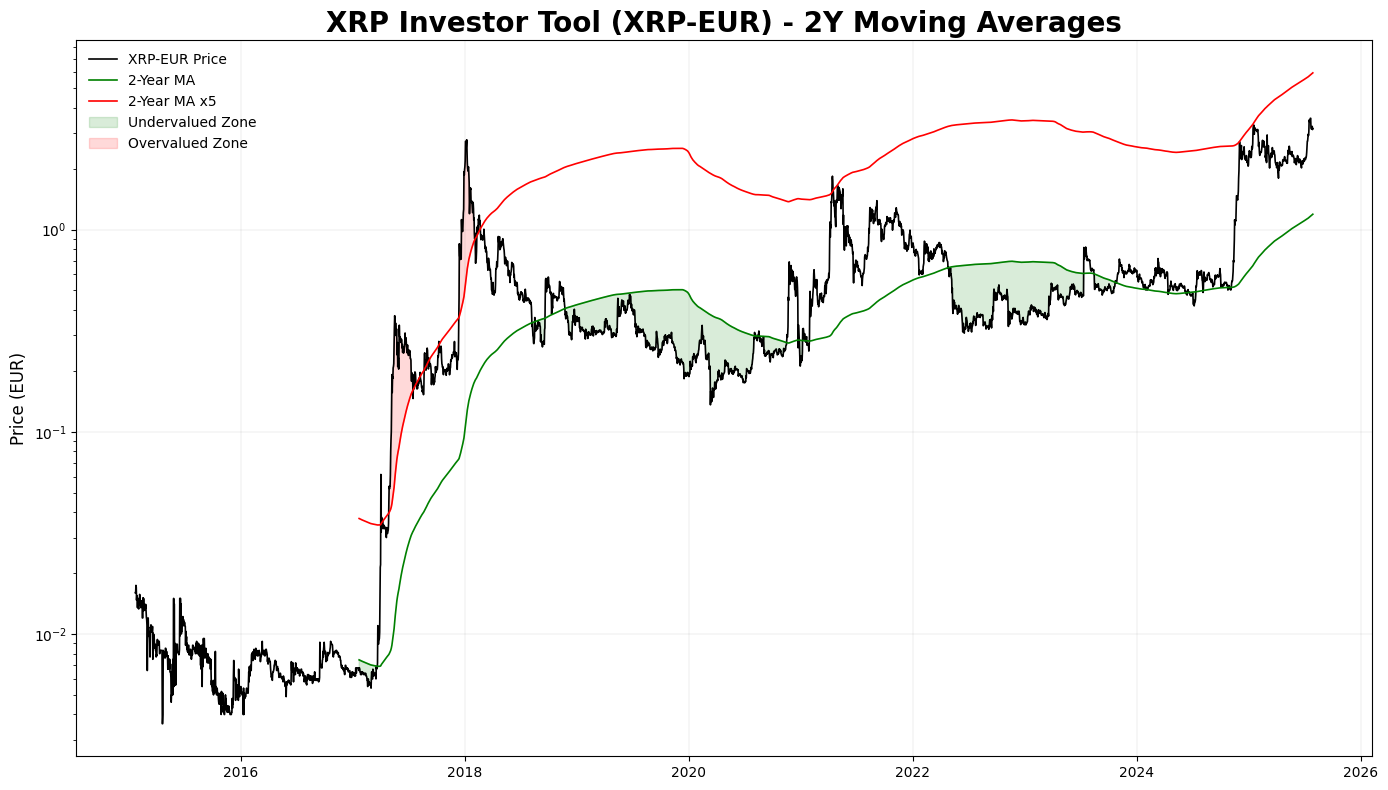

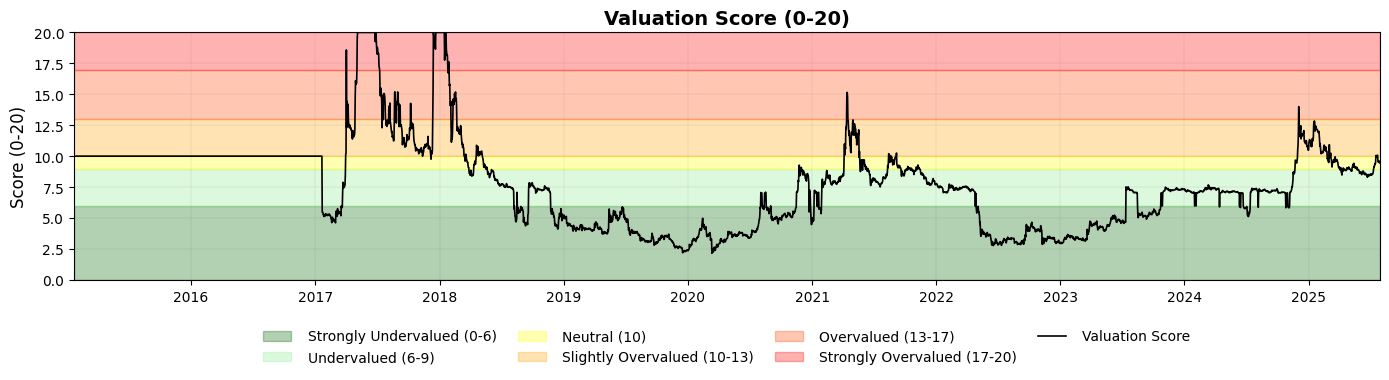

Document saved as XRP Analysis - 29-07-2025.docx


In [9]:
# Calculate 2-Year Moving Average (730 days) using the 'price' column
df['2Y_SMA'] = df['Close'].rolling(window=730, min_periods=1).mean()

# Calculate 5x of the 2-Year SMA
df['2Y_MA_5x'] = df['2Y_SMA'] * 5

# Displacement parameters
displacement_periods = 730  # Adjust this for how many periods to shift

# Displace the moving averages
df['DMA_2Y_SMA'] = df['2Y_SMA'].shift(-displacement_periods)  # Displaced 2-Year SMA
df['DMA_2Y_MA_5x'] = df['2Y_MA_5x'].shift(-displacement_periods)  # Displaced 5x of 2-Year SMA

# Create Undervalued and Overvalued indicators based on the displaced values
df['Undervalued'] = df['Close'] < df['DMA_2Y_SMA']
df['Overvalued'] = df['Close'] > df['DMA_2Y_MA_5x']

# Scoring System Calculation
df['Score'] = 10  # Default neutral value
df.loc[df['Close'] < df['DMA_2Y_SMA'], 'Score'] = 6 - (df['DMA_2Y_SMA'] - df['Close']) / df['DMA_2Y_SMA'] * 6
df.loc[(df['Close'] >= df['DMA_2Y_SMA']) & (df['Close'] <= df['DMA_2Y_MA_5x']), 'Score'] = 7 + (df['Close'] - df['DMA_2Y_SMA']) / (df['DMA_2Y_MA_5x'] - df['DMA_2Y_SMA']) * 6
df.loc[df['Close'] > df['DMA_2Y_MA_5x'], 'Score'] = 14 + (df['Close'] - df['DMA_2Y_MA_5x']) / df['DMA_2Y_MA_5x'] * 6
df['Score'] = df['Score'].clip(0, 20)  # Restrict values to 0-20


# Drop rows with NaN values in critical columns (for the backtest)
#df.dropna(subset=['DMA_2Y_SMA', 'DMA_2Y_MA_5x', 'Close','Score'], inplace=True)

# Score Interpretation
def interpret_score(score):
    if score <= 6:
        return "Strongly Undervalued"
    elif score <= 9:
        return "Undervalued"
    elif score == 10:
        return "Neutral"
    elif score <= 13:
        return "Slightly Overvalued"
    elif score <= 17:
        return "Overvalued"
    else:
        return "Strongly Overvalued"

df['Interpretation'] = df['Score'].apply(interpret_score)

# Create the document title with the current date
current_date = datetime.now().strftime("%d-%m-%Y")  # Format date as DD-MM-YYYY to avoid slashes
document_title = f'XRP Analysis - {current_date}'
name = f'Speedy Gonzalez @keepitcrypto'

# Create a new document
doc = Document()

# Set narrow margins by accessing the first section
section = doc.sections[0]
section.left_margin = Inches(0.5)
section.right_margin = Inches(0.5)
section.top_margin = Inches(0.5)
section.bottom_margin = Inches(0.5)

# Set 1.5 line spacing for the entire document
style = doc.styles['Normal']
style.paragraph_format.line_spacing_rule = WD_LINE_SPACING.ONE_POINT_FIVE

# Add a title and name to the document
doc.add_heading(document_title, level=1)
doc.add_heading(name, level=2)

# Plotting 2-Year Moving Averages
plt.figure(figsize=(14, 8))
plt.plot(df['Close'], label='XRP-EUR Price', color='black', linewidth=1.2)
plt.plot(df['DMA_2Y_SMA'], label='2-Year MA', color='green', linewidth=1.2)
plt.plot(df['DMA_2Y_MA_5x'], label='2-Year MA x5', color='red', linewidth=1.2)
plt.fill_between(df.index, df['DMA_2Y_SMA'], df['Close'], where=df['Undervalued'], color='green', alpha=0.15, label="Undervalued Zone")
plt.fill_between(df.index, df['DMA_2Y_MA_5x'], df['Close'], where=df['Overvalued'], color='red', alpha=0.15, label="Overvalued Zone")
plt.title("XRP Investor Tool (XRP-EUR) - 2Y Moving Averages", weight='bold', fontsize=20)
plt.ylabel("Price (EUR)", fontsize=12)
plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.grid(True, color='gray', linestyle='-', linewidth=0.2, alpha=0.5)
plt.yscale("log")
plt.tight_layout()
plot_filename = 'XRP_2y_ma.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

# Add main analysis to the document
paragraph = doc.add_paragraph()
title_run = paragraph.add_run('XRP Investor Tool - 2 Year MA')
title_run.bold = True

# Add description in a new paragraph
description_paragraph = doc.add_paragraph()
description_text = """The Investor Tool was created as a tool for long-term investors, indicating periods where prices are likely approaching cyclical tops or bottoms. The tool uses two simple moving averages of price as the basis for under/overvalued conditions: the 2-year MA (green) and a 5x multiple of the 2-year MA (red)."""
description_run = description_paragraph.add_run(description_text)
description_run.font.size = Pt(10)
description_paragraph.paragraph_format.space_after = Pt(0)

# Add bullet points
bullet_points = [
    "Price trading below the 2-year MA 🟢 has generated outsized returns, and signaled bear cycle lows.",
    "Price trading above the 2-year MA x5 🔴 has been signaled bull cycle tops and a zone where investors de-risk."
]

for point in bullet_points:
    bullet_paragraph = doc.add_paragraph(point, style='List Bullet')
    bullet_paragraph.paragraph_format.space_before = Pt(0)
    bullet_paragraph.paragraph_format.space_after = Pt(0)
    for run in bullet_paragraph.runs:
        run.font.size = Pt(10)
        
# Add plot to the document
image_paragraph = doc.add_paragraph()
image_paragraph.add_run().add_picture(plot_filename, width=Inches(7))
image_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

# Plotting Score and Interpretation Zones
plt.figure(figsize=(14, 4))

# Highlight zones for valuation interpretation
plt.axhspan(0, 6, color='darkgreen', alpha=0.3, label='Strongly Undervalued (0-6)')
plt.axhspan(6, 9, color='lightgreen', alpha=0.3, label='Undervalued (6-9)')
plt.axhspan(9, 10, color='yellow', alpha=0.3, label='Neutral (10)')
plt.axhspan(10, 13, color='orange', alpha=0.3, label='Slightly Overvalued (10-13)')
plt.axhspan(13, 17, color='orangered', alpha=0.3, label='Overvalued (13-17)')
plt.axhspan(17, 20, color='red', alpha=0.3, label='Strongly Overvalued (17-20)')

# Plot the valuation score
plt.plot(df.index, df['Score'], color='black', linewidth=1.2, label='Valuation Score')

# Set x-axis to match the 2-Year Moving Averages plot
plt.xlim(df.index.min(), df.index.max())  # Synchronize x-axis with the main plot

# Formatting the plot
plt.title("Valuation Score (0-20)", fontsize=14, weight='bold')
plt.ylabel("Score (0-20)", fontsize=12)
plt.ylim(0, 20)  # Ensure consistent score range
# Placing a wider legend below the plot
plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15),  # Centered and moved below the plot
    fontsize=10, 
    frameon=False, 
    ncol=4,  # More columns to make the legend wider
    columnspacing=1.5,  # Adjust spacing between columns
    handletextpad=1.2    # Adjust spacing between legend symbols and text
)
plt.grid(True, color='gray', linestyle='-', linewidth=0.2, alpha=0.5)
plt.tight_layout()

# Save the score plot
score_plot_filename = 'XRP_score_plot.png'
plt.savefig(score_plot_filename, dpi=300, bbox_inches='tight')
plt.show()

# Add score plot to document
image_paragraph = doc.add_paragraph()
image_paragraph.add_run().add_picture(score_plot_filename, width=Inches(7))
image_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

# Page-Break
doc.add_page_break()

# Technical Analysis Section
latest_row = df.iloc[0]
latest_price = latest_row['Close']
latest_score = latest_row['Score']
interpretation = latest_row['Interpretation']
distance_from_2y = (latest_price - latest_row['DMA_2Y_SMA']) / latest_row['DMA_2Y_SMA'] * 100
support = latest_row['DMA_2Y_SMA']
resistance = latest_row['DMA_2Y_MA_5x']

paragraph = doc.add_paragraph()
run = paragraph.add_run("Current Market Status\n")
run.bold = True
run.font.size = Pt(11)
paragraph.add_run(f"As of {current_date}, Ripple is trading at €{latest_price:,.2f}.\n").font.size = Pt(10)

#paragraph = doc.add_paragraph()
run = paragraph.add_run("Valuation Analysis\n")
run.bold = True
run.font.size = Pt(11)
paragraph.add_run(
    f"Our 2-Year Moving Average model indicates a valuation score of {latest_score:,.2f}/20, "
    f"suggesting that Ripple is currently **{interpretation}**. The price is trading "
    f"{distance_from_2y:.1f}% {'above' if distance_from_2y > 0 else 'below'} the 2-Year Moving Average. "
).font.size = Pt(10)

outlook_paragraph = doc.add_paragraph(style='List Bullet')
outlook_paragraph.add_run(f"Support: €{support:,.2f} (2-Year Moving Average)").font.size = Pt(10)
outlook_paragraph = doc.add_paragraph(style='List Bullet')
outlook_paragraph.add_run(f"Resistance: €{resistance:,.2f} (5x 2-Year Moving Average)").font.size = Pt(10)

# Parapgraph
doc.add_paragraph()

#Add Page-Break
#doc.add_page_break()

# Save Document
doc_filename = f'{document_title}.docx'
doc.save(doc_filename)
print(f"Document saved as {doc_filename}")



In [10]:
df.rename(columns={'Score': 'score_2yr_ma'}, inplace=True)

# 

# 

# Pi Cycle Top

## Pi Cycle Oscillator=1−(111_SMA/2x_350_SMA)

Works by comparing the momentum of two moving average indicators. It compares the 111 SMA 🔵 and 2 * 350 SMA 🟣 of Bitcoin’s Price. These two moving averages were selected as 350 / 111 = 3.153; An approximation of the Pi number.

When the 111 SMA 🔵 meets the 2 * 350 SMA 🟣, it is an indication of an overheated market. The mid timeframe momentum reference crosses above the long timeframe momentum reference.

When the 111 SMA 🔵 falls beneath the 2 * 350 SMA 🟣, it is an indication of a deflating market that is cooling of after a period of overheating. Shown in green are points where the 111 SMA is trading at a 75% discount to the 2 * 350 SMA.

## new code

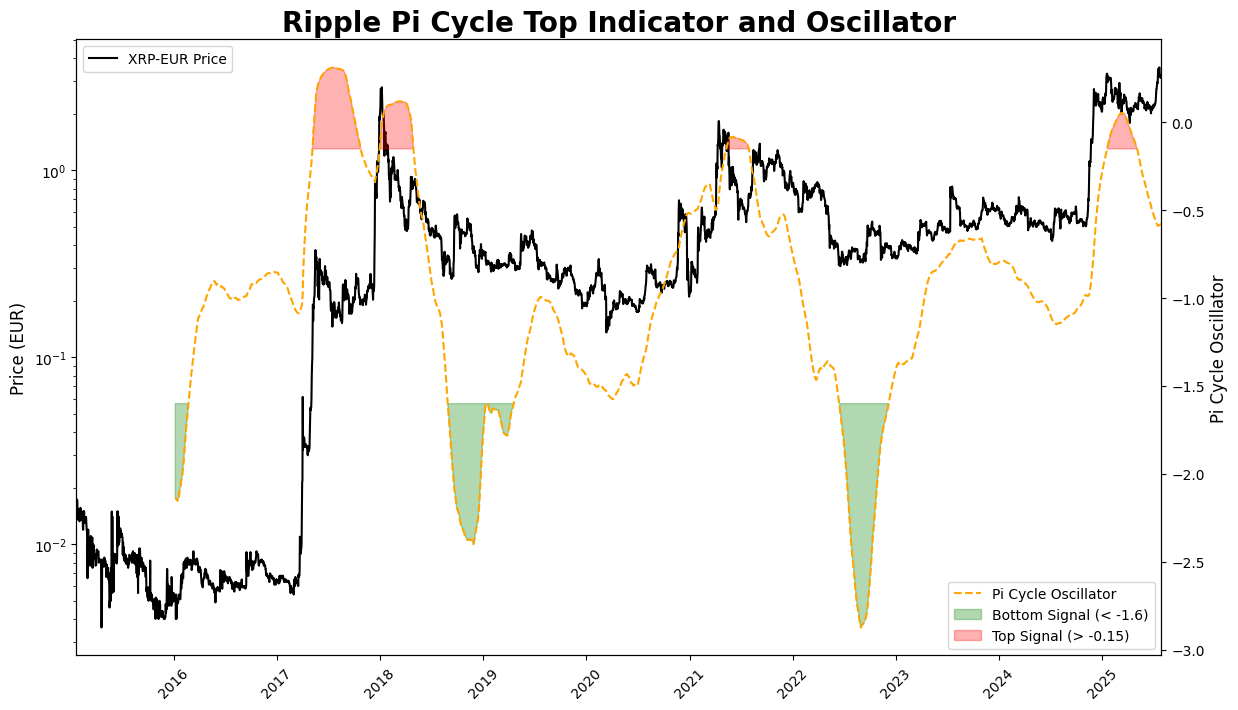

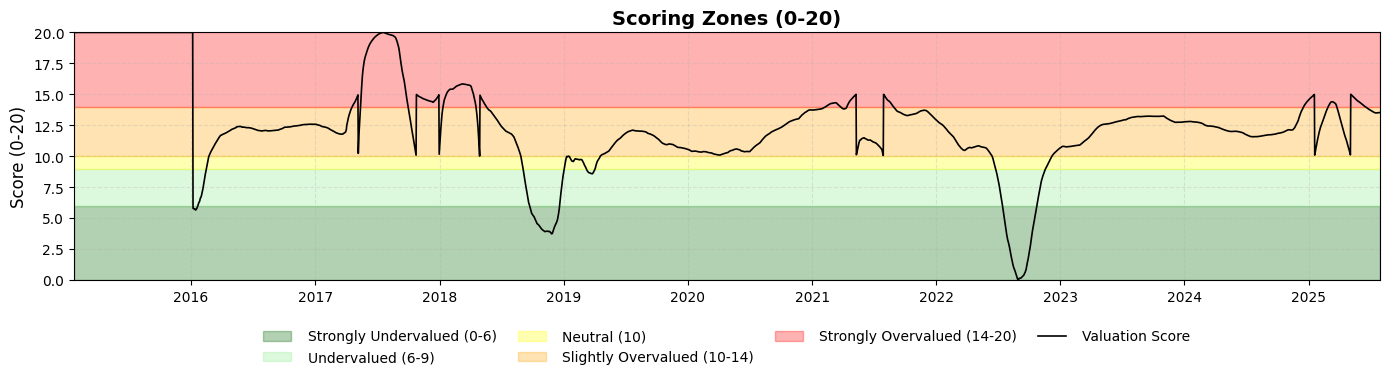

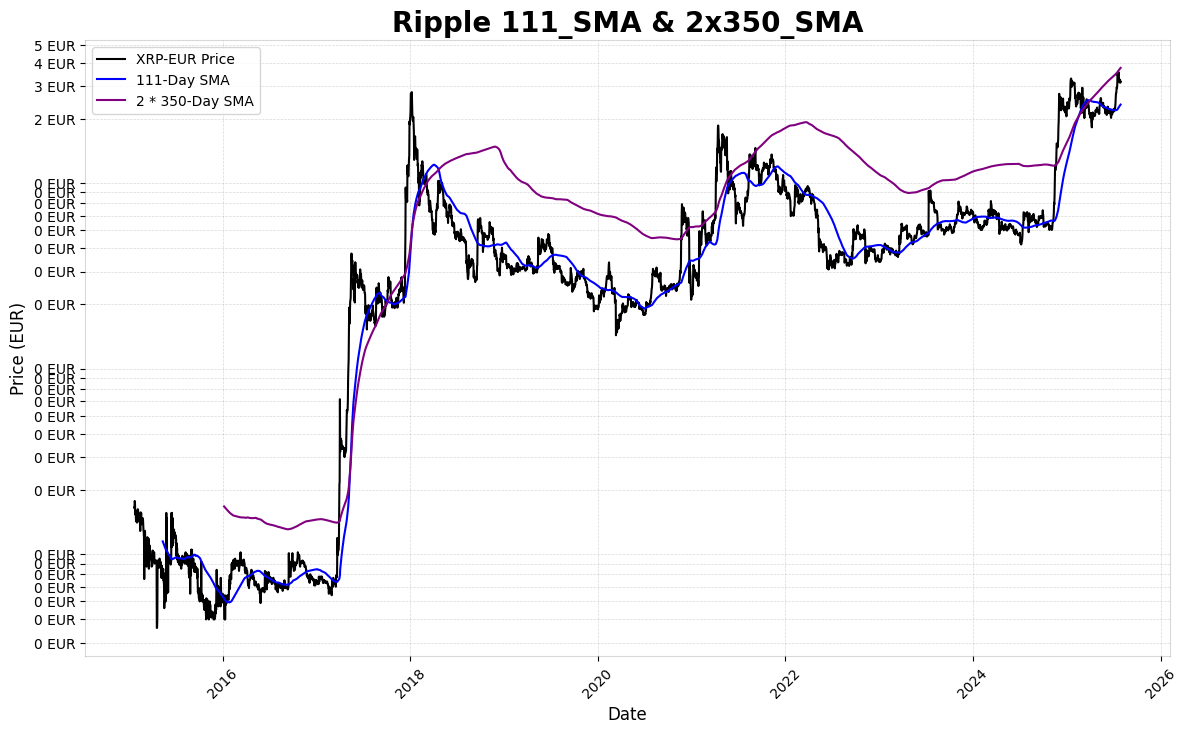

In [11]:
# Calculate the 111-Day Simple Moving Average (SMA)
df['111_SMA'] = df['Close'].rolling(window=111, min_periods=1).mean()

# Calculate the 350-Day Simple Moving Average (SMA)
df['350_SMA'] = df['Close'].rolling(window=350, min_periods=1).mean()

# Calculate 2 * 350-Day SMA (as a proxy for Pi Cycle)
df['2x_350_SMA'] = df['350_SMA'] * 2

# Displacement parameters
displacement_periods1 = 350
displacement_periods2 = 111

# Displace the moving averages
df['111_SMA'] = df['111_SMA'].shift(-displacement_periods2)
df['2x_350_SMA'] = df['2x_350_SMA'].shift(-displacement_periods1)

# Drop rows with NaN values in critical columns
#df.dropna(subset=['111_SMA', '2x_350_SMA', 'Close'], inplace=True)

# Calculate the Pi Cycle Oscillator
df['Pi_Cycle_Oscillator'] = 1 - (df['2x_350_SMA'] / df['111_SMA'])

def calculate_proportional_score(pi_osc, lower_limit=-1.6, upper_limit=-0.15, historical_min=None, historical_max=None):
    """
    Dynamically calculate a proportional score based on the Pi Cycle Oscillator's
    position relative to undervalued, neutral, and overvalued thresholds.

    Args:
        pi_osc (float): Current Pi Cycle Oscillator value.
        lower_limit (float): Threshold for undervalued condition.
        upper_limit (float): Threshold for overvalued condition.
        historical_min (float): Minimum value of the oscillator in historical data.
        historical_max (float): Maximum value of the oscillator in historical data.

    Returns:
        float: Score between 0 and 20.
    """
    if historical_min is None or historical_max is None:
        raise ValueError("Historical min and max values must be provided.")

    # Normalize the oscillator to a 0–1 range based on historical data
    normalized_osc = (pi_osc - historical_min) / (historical_max - historical_min)

    # Calculate score proportionally
    if pi_osc <= lower_limit:
        # Strongly undervalued zone: Scale between 0 and 10
        score = 10 - (abs(pi_osc - lower_limit) / abs(lower_limit - historical_min)) * 10
    elif pi_osc >= upper_limit:
        # Strongly overvalued zone: Scale between 10 and 20
        score = 10 + (abs(pi_osc - upper_limit) / abs(historical_max - upper_limit)) * 10
    else:
        # Neutral zone: Scale linearly between 10 and 15
        relative_position = (pi_osc - lower_limit) / (upper_limit - lower_limit)
        score = 10 + relative_position * 5

    # Clip score to the 0–20 range
    return max(0, min(20, score))

# Historical min and max values for normalization
historical_min = df['Pi_Cycle_Oscillator'].min()
historical_max = df['Pi_Cycle_Oscillator'].max()

# Apply the scoring function to the DataFrame
df['Score_Pi'] = df['Pi_Cycle_Oscillator'].apply(
    calculate_proportional_score,
    args=(-1.6, -0.15, historical_min, historical_max)
)

# Interpretation of Score
def interpret_score(score):
    if score <= 6:
        return "Strongly Undervalued"
    elif score <= 9:
        return "Undervalued"
    elif score == 10:
        return "Neutral"
    elif score <= 14:
        return "Slightly Overvalued"
    else:
        return "Strongly Overvalued"

df['Interpretation_Pi'] = df['Score_Pi'].apply(interpret_score)

# Define date range for alignment
start_date = df.index.min()
end_date = df.index.max()

# Plot Pi Cycle Oscillator
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(df['Close'], label='XRP-EUR Price', color='black', linewidth=1.5)
ax1.set_ylabel("Price (EUR)", fontsize=12)
ax1.set_yscale("log")
ax1.tick_params(axis='x', labelsize=10, rotation=45)
ax1.set_xlim(start_date, end_date)

ax2 = ax1.twinx()
ax2.plot(df['Pi_Cycle_Oscillator'], label='Pi Cycle Oscillator', color='orange', linestyle='--', linewidth=1.5)
ax2.set_ylabel("Pi Cycle Oscillator", fontsize=12)
ax2.fill_between(df.index, df['Pi_Cycle_Oscillator'], -1.6, 
                 where=(df['Pi_Cycle_Oscillator'] < -1.6), color='green', alpha=0.3, label="Bottom Signal (< -1.6)")
ax2.fill_between(df.index, df['Pi_Cycle_Oscillator'], -0.15, 
                 where=(df['Pi_Cycle_Oscillator'] > -0.15), color='red', alpha=0.3, label="Top Signal (> -0.15)")
ax1.legend(loc="upper left", fontsize=10)
ax2.legend(loc="lower right", fontsize=10)
plt.title("Ripple Pi Cycle Top Indicator and Oscillator", weight='bold', fontsize=20)
plot_filename1 = 'XRP_pi_cycle.png'
plt.savefig(plot_filename1, dpi=300, bbox_inches='tight')
plt.show()

# Scoring Zones Plot
plt.figure(figsize=(14, 4))
plt.axhspan(0, 6, color='darkgreen', alpha=0.3, label='Strongly Undervalued (0-6)')
plt.axhspan(6, 9, color='lightgreen', alpha=0.3, label='Undervalued (6-9)')
plt.axhspan(9, 10, color='yellow', alpha=0.3, label='Neutral (10)')
plt.axhspan(10, 14, color='orange', alpha=0.3, label='Slightly Overvalued (10-14)')
plt.axhspan(14, 20, color='red', alpha=0.3, label='Strongly Overvalued (14-20)')
plt.plot(df.index, df['Score_Pi'], color='black', linewidth=1.2, label='Valuation Score')
plt.title("Scoring Zones (0-20)", fontsize=14, weight='bold')
plt.ylabel("Score (0-20)", fontsize=12)
plt.ylim(0, 20)
plt.xlim(start_date, end_date)
plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15),  # Centered and moved below the plot
    fontsize=10, 
    frameon=False, 
    ncol=4,  # More columns to make the legend wider
    columnspacing=1.5,  # Adjust spacing between columns
    handletextpad=1.2    # Adjust spacing between legend symbols and text
)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
score_plot_filename = 'XRP_score_zones.png'
plt.savefig(score_plot_filename, dpi=300, bbox_inches='tight')
plt.show()

# Create a single paragraph
paragraph = doc.add_paragraph()

# Add the title and make it bold
title_run = paragraph.add_run('Ripple Pi Cycle Indicator Plot')
title_run.bold = True

# Add the descriptive text directly after the line break in the same paragraph
description_text = """
The Pi Cycle Indicator works by comparing the momentum of two moving average indicators: the 111-day SMA 🔵 and the 2 * 350-day SMA 🟣. These two averages, with a ratio close to the Pi constant (3.1415), signal overbought or oversold conditions.
"""

# Add the descriptive text with a specified font size
run = paragraph.add_run(description_text)
run.font.size = Pt(10)  # Set the font size (e.g., 12 points)


# Plot the data
plt.figure(figsize=(14, 8))

# Plot XRP-EUR price
plt.plot(df['Close'], label='XRP-EUR Price', color='black')

# Plot moving averages
plt.plot(df['111_SMA'], label='111-Day SMA', color='blue')
plt.plot(df['2x_350_SMA'], label='2 * 350-Day SMA', color='purple')

# Set y-axis to be logarithmic with customized tick format
plt.yscale("log")
plt.gca().yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs='auto', numticks=10))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,} EUR"))

# Customize x-axis ticks and add labels
plt.xticks(fontsize=10, rotation=45)  # Smaller and angled x-ticks for clarity

# Reduce axis line thickness and color to very light grey (with transparency)
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_linewidth(0.8)
    plt.gca().spines[spine].set_color('gray')
    plt.gca().spines[spine].set_alpha(0.3)  # Add transparency

# Set the title and labels
plt.title("Ripple 111_SMA & 2x350_SMA", weight='bold', fontsize=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (EUR)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)

# Display grid with light styling
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Save the plot as an image

# Define the path to the existing 'Plots' folder
plot_filename = f'XRP_111_2x350_sma.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

#Add plot to the document
# Create a new paragraph specifically for the image
image_paragraph = doc.add_paragraph()
run = image_paragraph.add_run()
run.add_picture(plot_filename, width=Inches(7))

# Center the paragraph that contains the image
image_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

# Add the two pieces of text as bullet points without additional spacing
bullet_points = [
    "When the 111-day SMA crosses above the 2 * 350-day SMA, it may indicate an overheated market, while a cross below suggests a cooling period. Highlighted areas show potential cyclical lows (green) and highs (red), based on oscillator values."
]

for point in bullet_points:
    bullet_paragraph = doc.add_paragraph(point, style='List Bullet')
    bullet_paragraph.paragraph_format.space_before = Pt(0)

    # Set font size for each bullet point text
    for run in bullet_paragraph.runs:
        run.font.size = Pt(10)  # Set the font size (e.g., 12 points)


# Add Plots to Document
image_paragraph = doc.add_paragraph()
image_paragraph.add_run().add_picture(plot_filename1, width=Inches(7))
image_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

image_paragraph = doc.add_paragraph()
image_paragraph.add_run().add_picture(score_plot_filename, width=Inches(6))
image_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

# Add Analysis
#doc.add_paragraph("Technical Analysis", style='Heading 2')
paragraph = doc.add_paragraph()
run = paragraph.add_run("Technical Analysis")
run.bold = True
run.font.size = Pt(11)

latest_row = df.iloc[0]
# Prepare the analysis text
analysis_text = (
    f"The Pi Cycle Oscillator is {latest_row['Pi_Cycle_Oscillator']:.2f}, "
    f"indicating that Ripple is currently **{latest_row['Interpretation_Pi']}** with a valuation score of {latest_row['Score_Pi']:.2f}/20."
)

# Add the analysis text to the document and set the font size to 10
paragraph = doc.add_paragraph()
run = paragraph.add_run(analysis_text)
run.font.size = Pt(10)  # Set font size to 10 points

#Add Page-Break
doc.add_page_break()

# Save Document
doc.save(f'{document_title}.docx')

In [12]:
df.head(10)

,Close,Open,High,Low,Vol.,Change %,2Y_SMA,2Y_MA_5x,DMA_2Y_SMA,DMA_2Y_MA_5x,Undervalued,Overvalued,score_2yr_ma,Interpretation,111_SMA,350_SMA,2x_350_SMA,Pi_Cycle_Oscillator,Score_Pi,Interpretation_Pi
Date,,,,,,,,,,,,,,,,,,,,
2025-07-29,3.1603,3.1223,3.1852,3.0826,489910000,1.22%,3.160300,15.801500,1.190998,5.954990,False,False,9.480233,Slightly Overvalued,2.381110,3.160300,3.754026,-0.576587,13.529011,Slightly Overvalued
2025-07-28,3.1223,3.2388,3.3296,3.1101,669200000,-3.59%,3.141300,15.706500,1.187697,5.938484,False,False,9.443305,Slightly Overvalued,2.369158,3.141300,3.739434,-0.578381,13.522824,Slightly Overvalued
2025-07-27,3.2386,3.1660,3.2504,3.1585,304900000,2.30%,3.173733,15.868667,1.184238,5.921191,False,False,9.602131,Slightly Overvalued,2.357072,3.173733,3.724085,-0.579962,13.517372,Slightly Overvalued
2025-07-26,3.1658,3.1420,3.2173,3.1094,233600000,0.77%,3.171750,15.858750,1.180883,5.904414,False,False,9.521314,Slightly Overvalued,2.345861,3.171750,3.709335,-0.581225,13.513016,Slightly Overvalued
2025-07-25,3.1417,3.1448,3.1603,3.0035,581480000,-0.10%,3.165740,15.828700,1.177550,5.887751,False,False,9.501995,Slightly Overvalued,2.336878,3.165740,3.694702,-0.581042,13.513650,Slightly Overvalued
2025-07-24,3.1448,3.1829,3.2639,2.9686,944090000,-1.21%,3.162250,15.811250,1.174204,5.871021,False,False,9.517359,Slightly Overvalued,2.327734,3.162250,3.680258,-0.581047,13.513630,Slightly Overvalued
2025-07-23,3.1834,3.5514,3.5514,3.0585,1070000000,-10.37%,3.165271,15.826357,1.170855,5.854275,False,False,9.578302,Slightly Overvalued,2.317642,3.165271,3.665495,-0.581562,13.511855,Slightly Overvalued
2025-07-22,3.5515,3.5501,3.5778,3.4240,633680000,0.03%,3.213550,16.067750,1.166994,5.834969,False,False,10.064934,Slightly Overvalued,2.303863,3.213550,3.648093,-0.583468,13.505284,Slightly Overvalued
2025-07-21,3.5506,3.4554,3.6480,3.4092,714710000,2.74%,3.251000,16.255000,1.163187,5.815933,False,False,10.078715,Slightly Overvalued,2.291143,3.251000,3.630595,-0.584622,13.501304,Slightly Overvalued


# 

# 

# Mayer Multiple

# Step 1: Calculate the 200-Day Moving Average (200DMA)
df['200DMA'] = df['Close'].rolling(window=200).mean()

# Displacement parameters
displacement_periods = 200  # Adjust this for how many periods to shift

# Displace the moving averages
df['200DMA'] = df['200DMA'].shift(-displacement_periods)  # Displaced 200 DMA

# Drop rows with NaN values in critical columns (for the backtest)
df.dropna(subset=['200DMA'], inplace=True)

# Step 2: Calculate the Mayer Multiple
df['Mayer Multiple'] = df['Close'] / df['200DMA']

# Step 3: Calculate the Bottom and Top Models
df['Mayer Multiple Bottom (0.8x)'] = df['200DMA'] * 0.8
df['Mayer Multiple Top (2.4x)'] = df['200DMA'] * 2.4

# Define the overbought and oversold levels
overbought_level = 2.4
oversold_level = 0.8

# Set up the figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# ==============================
# First Plot: BTC Price, 200DMA, and Threshold Lines
# ==============================
ax1.plot(df['Close'], label='BTC-EUR Price', color='black', linewidth=1.5)
ax1.plot(df['200DMA'], label='200-Day SMA', color='blue', linewidth=1.5)
ax1.plot(df['200DMA'] * 2.4, label='Overvalued Level (200DMA * 2.4)', color='red', linestyle='--', linewidth=1.5)
ax1.plot(df['200DMA'] * 0.8, label='Undervalued Level (200DMA * 0.8)', color='green', linestyle='--', linewidth=1.5)

# Highlight overbought and oversold zones based on the Mayer Multiple
ax1.fill_between(df.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=(df['Mayer Multiple'] > overbought_level),
                 color='red', alpha=0.1, label="Overbought Zone (Mayer Multiple > 2.4)")
ax1.fill_between(df.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=(df['Mayer Multiple'] < oversold_level),
                 color='green', alpha=0.1, label="Oversold Zone (Mayer Multiple < 0.8)")

# Set y-axis to logarithmic scale
ax1.set_yscale("log")
ax1.set_ylabel("Price (EUR)", fontsize=12)
ax1.set_title("Bitcoin Price with 200-Day Moving Average and Thresholds", fontsize=16, weight='bold')

# Customize y-axis for price plot
ax1.yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,} EUR"))

# Add legend and grid
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# =========================
# Second Plot: Mayer Multiple with Highlighted Zones
# =========================
ax2.plot(df['Mayer Multiple'], label='Mayer Multiple', color='purple', linewidth=1.5)
ax2.axhline(overbought_level, color='red', linestyle='--', linewidth=1.2, label='Overbought Level (2.4)')
ax2.axhline(oversold_level, color='green', linestyle='--', linewidth=1.2, label='Oversold Level (0.8)')

# Highlight overbought and oversold zones
#ax2.fill_between(df.index, overbought_level, ax2.get_ylim()[1], where=(df['Mayer Multiple'] > overbought_level),
#                 color='red', alpha=0.3, label="Overbought Zone")
#ax2.fill_between(df.index, ax2.get_ylim()[0], oversold_level, where=(df['Mayer Multiple'] < oversold_level),
#                 color='green', alpha=0.3, label="Oversold Zone")

# Set y-axis limits and labels for the Mayer Multiple plot
ax2.set_ylabel("Mayer Multiple", fontsize=12)
ax2.set_title("Mayer Multiple with Overbought and Oversold Zones", fontsize=16, weight='bold')

# Customize y-axis ticks
ax2.yaxis.set_major_locator(mticker.MultipleLocator(2))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(0.5))
ax2.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Add legend for the Mayer Multiple plot
ax2.legend(loc="upper left", fontsize=10)

# =========================
# Shared X-Axis Customization
# =========================
plt.xticks(fontsize=10, rotation=45)
ax2.set_xlabel("Date", fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save the combined plot as an image
#plot_filename = f'btc_mayer_multiple_{current_date}.png'
plot_filename = f'btc_mayer_multiple.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

# =========================
# Add Plots to the Document
# =========================
# Create a single paragraph
paragraph = doc.add_paragraph()

# Add the title and make it bold
title_run = paragraph.add_run('Bitcoin Mayer Multiple Model')
title_run.bold = True

# Add the descriptive text directly after the line break in the same paragraph
description_text = """
The Mayer Multiple is an oscillator calculated as the ratio between price and the 200-day moving average (200DMA). The 200DMA is a widely recognized indicator for establishing macro bull or bear bias. The Mayer Multiple therefore represents a measure of distance away from this long-term average price as a tool to gauge overbought and oversold conditions.
"""
# Add the descriptive text with a specified font size
run = paragraph.add_run(description_text)
run.font.size = Pt(10)  # Set the font size (e.g., 12 points)


# Add the combined plot image to the document, centered
image_paragraph = doc.add_paragraph()
run = image_paragraph.add_run()
run.add_picture(plot_filename, width=Inches(7))
image_paragraph.alignment = 1  # Center the image


# Add the piece of text as bullet points without additional spacing
#bullet_points = [
#"Values below 0.8 (🟢) represent prices trading at a 20% discount to the 200-day MA, often indicating bear market lows.",
#"Values above 2.4 (🔴) represent prices trading at a premium of 240% above the 200-day MA, often indicating bull market peaks."
#"The Mayer Multiple is {latest_row['Mayer Multiple']:.2f}, "
#]

bullet_points = [
    "Values below 0.8 (🟢) represent prices trading at a 20% discount to the 200-day MA, often indicating bear market lows.",
    "Values above 2.4 (🔴) represent prices trading at a premium of 240% above the 200-day MA, often indicating bull market peaks.",
    "The Mayer Multiple is {:.2f}.".format(latest_row['Mayer Multiple'])
]

for point in bullet_points:
    bullet_paragraph = doc.add_paragraph(point, style='List Bullet')
    bullet_paragraph.paragraph_format.space_before = Pt(0)

    # Set font size for each bullet point text
    for run in bullet_paragraph.runs:
        run.font.size = Pt(10)  # Set the font size (e.g., 12 points)  

#Add Page-Break
doc.add_page_break()

# Save the document
doc_filename = f'{document_title}.docx'
doc.save(doc_filename)

# Confirm the document was saved
print(f"Document saved as: {doc_filename}")

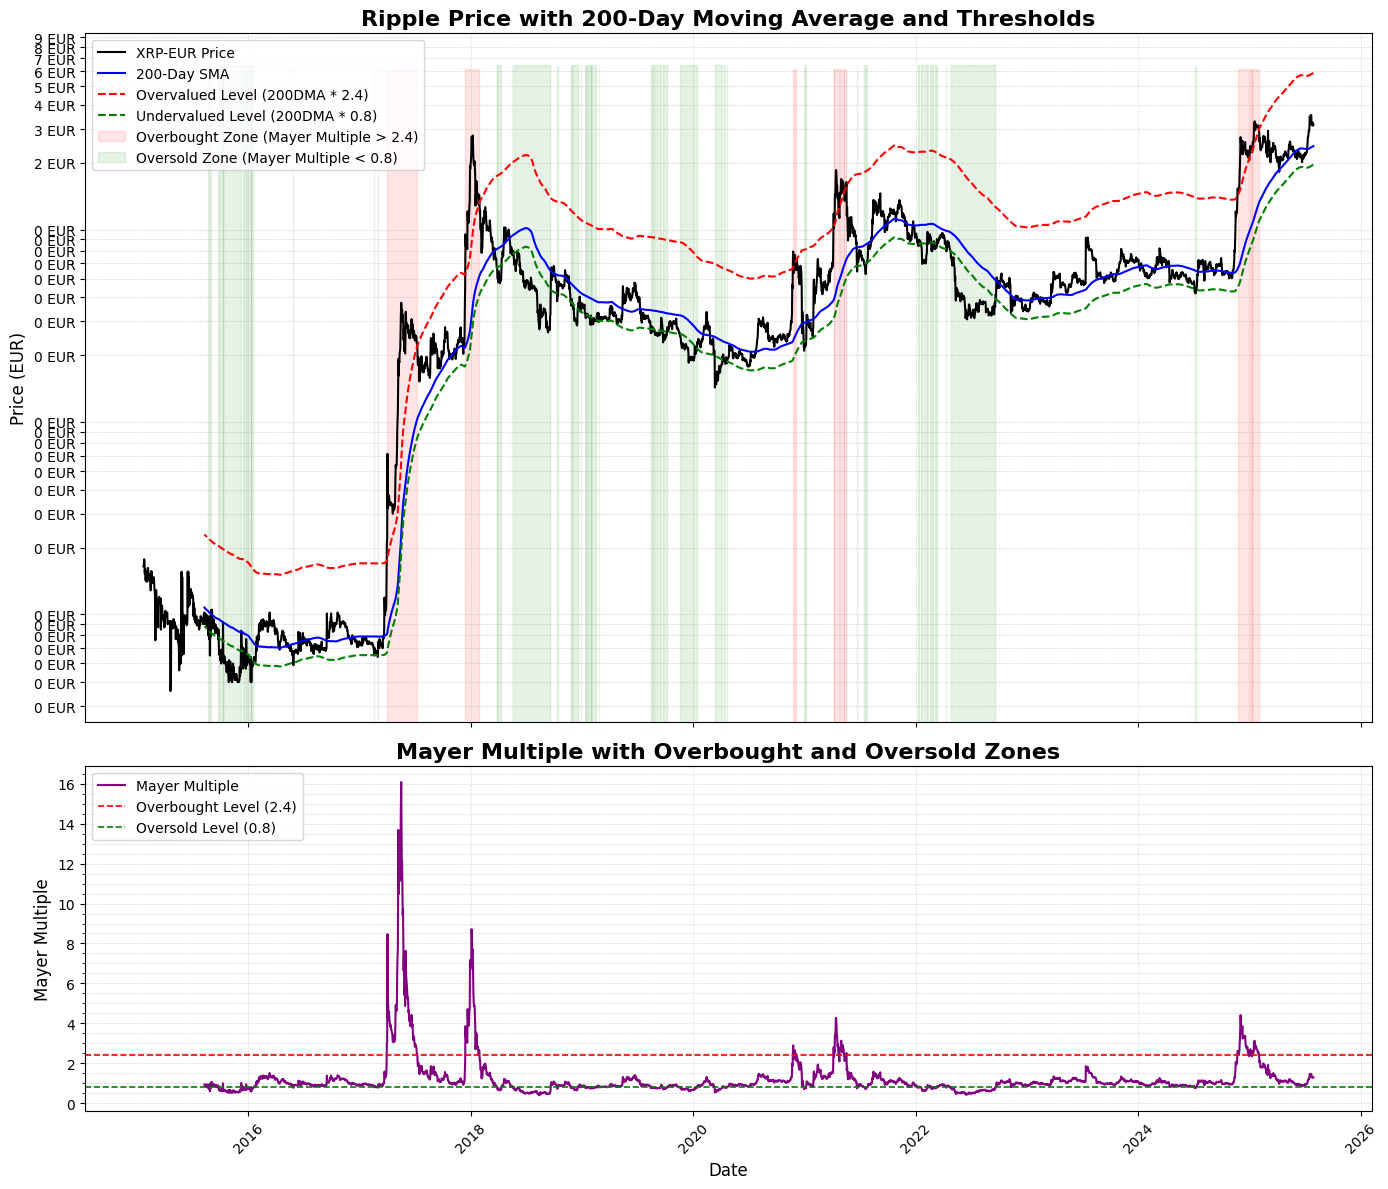

Document saved as: XRP Analysis - 29-07-2025.docx


In [13]:
# Step 1: Calculate the 200-Day Moving Average (200DMA)
df['200DMA'] = df['Close'].rolling(window=200).mean()

# Displacement parameters
displacement_periods = 200  # Adjust this for how many periods to shift

# Displace the moving averages
df['200DMA'] = df['200DMA'].shift(-displacement_periods)  # Displaced 200 DMA

# Drop rows with NaN values in critical columns (for the backtest)
#df.dropna(subset=['200DMA'], inplace=True)

# Step 2: Calculate the Mayer Multiple
df['Mayer Multiple'] = df['Close'] / df['200DMA']

# Step 3: Calculate the Bottom and Top Models
df['Mayer Multiple Bottom (0.8x)'] = df['200DMA'] * 0.8
df['Mayer Multiple Top (2.4x)'] = df['200DMA'] * 2.4

# Define the overbought and oversold levels
overbought_level = 2.4
oversold_level = 0.8

# Set up the figure with two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# ==============================
# First Plot: XRP Price, 200DMA, and Threshold Lines
# ==============================
ax1.plot(df['Close'], label='XRP-EUR Price', color='black', linewidth=1.5)
ax1.plot(df['200DMA'], label='200-Day SMA', color='blue', linewidth=1.5)
ax1.plot(df['200DMA'] * 2.4, label='Overvalued Level (200DMA * 2.4)', color='red', linestyle='--', linewidth=1.5)
ax1.plot(df['200DMA'] * 0.8, label='Undervalued Level (200DMA * 0.8)', color='green', linestyle='--', linewidth=1.5)

# Highlight overbought and oversold zones based on the Mayer Multiple
ax1.fill_between(df.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=(df['Mayer Multiple'] > overbought_level),
                 color='red', alpha=0.1, label="Overbought Zone (Mayer Multiple > 2.4)")
ax1.fill_between(df.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=(df['Mayer Multiple'] < oversold_level),
                 color='green', alpha=0.1, label="Oversold Zone (Mayer Multiple < 0.8)")

# Set y-axis to logarithmic scale
ax1.set_yscale("log")
ax1.set_ylabel("Price (EUR)", fontsize=12)
ax1.set_title("Ripple Price with 200-Day Moving Average and Thresholds", fontsize=16, weight='bold')

# Customize y-axis for price plot
ax1.yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,} EUR"))

# Add legend and grid
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# =========================
# Second Plot: Mayer Multiple with Highlighted Zones
# =========================
ax2.plot(df['Mayer Multiple'], label='Mayer Multiple', color='purple', linewidth=1.5)
ax2.axhline(overbought_level, color='red', linestyle='--', linewidth=1.2, label='Overbought Level (2.4)')
ax2.axhline(oversold_level, color='green', linestyle='--', linewidth=1.2, label='Oversold Level (0.8)')

# Highlight overbought and oversold zones
#ax2.fill_between(df.index, overbought_level, ax2.get_ylim()[1], where=(df['Mayer Multiple'] > overbought_level),
#                 color='red', alpha=0.3, label="Overbought Zone")
#ax2.fill_between(df.index, ax2.get_ylim()[0], oversold_level, where=(df['Mayer Multiple'] < oversold_level),
#                 color='green', alpha=0.3, label="Oversold Zone")

# Set y-axis limits and labels for the Mayer Multiple plot
ax2.set_ylabel("Mayer Multiple", fontsize=12)
ax2.set_title("Mayer Multiple with Overbought and Oversold Zones", fontsize=16, weight='bold')

# Customize y-axis ticks
ax2.yaxis.set_major_locator(mticker.MultipleLocator(2))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(0.5))
ax2.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Add legend for the Mayer Multiple plot
ax2.legend(loc="upper left", fontsize=10)

# =========================
# Shared X-Axis Customization
# =========================
plt.xticks(fontsize=10, rotation=45)
ax2.set_xlabel("Date", fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save the combined plot as an image
#plot_filename = f'btc_mayer_multiple_{current_date}.png'
plot_filename = f'XRP_mayer_multiple.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

# =========================
# Add Plots to the Document
# =========================
# Create a single paragraph
paragraph = doc.add_paragraph()

# Add the title and make it bold
title_run = paragraph.add_run('Ripple Mayer Multiple Model')
title_run.bold = True

# Add the descriptive text directly after the line break in the same paragraph
description_text = """
The Mayer Multiple is an oscillator calculated as the ratio between price and the 200-day moving average (200DMA). The 200DMA is a widely recognized indicator for establishing macro bull or bear bias. The Mayer Multiple therefore represents a measure of distance away from this long-term average price as a tool to gauge overbought and oversold conditions.
"""
# Add the descriptive text with a specified font size
run = paragraph.add_run(description_text)
run.font.size = Pt(10)  # Set the font size (e.g., 12 points)


# Add the combined plot image to the document, centered
image_paragraph = doc.add_paragraph()
run = image_paragraph.add_run()
run.add_picture(plot_filename, width=Inches(7))
image_paragraph.alignment = 1  # Center the image

# Ensure latest_row is the last row of your DataFrame
latest_row = df.iloc[0]

# Extract the relevant values
latest_close = latest_row['Close']
latest_mayer_multiple = latest_row['Mayer Multiple']
latest_200dma = latest_row['200DMA']
latest_overvalued_level = latest_row['Mayer Multiple Top (2.4x)']
latest_undervalued_level = latest_row['Mayer Multiple Bottom (0.8x)']

# Generate bullet points with the extracted values
bullet_points = [
    f"Values below 0.8 (🟢) represent prices trading at a 20% discount to the 200-day MA, often indicating bear market lows.",
    f"Values above 2.4 (🔴) represent prices trading at a premium of 240% above the 200-day MA, often indicating bull market peaks.",
    f"The latest Mayer Multiple is {latest_mayer_multiple:.2f}.",
    f"The 200-Day Moving Average is {latest_200dma:.2f} EUR.",
    f"The overvalued level (2.4x 200DMA) is {latest_overvalued_level:.2f} EUR.",
    f"The undervalued level (0.8x 200DMA) is {latest_undervalued_level:.2f} EUR."
]

# Add bullet points to the document
for point in bullet_points:
    bullet_paragraph = doc.add_paragraph(point, style='List Bullet')
    bullet_paragraph.paragraph_format.space_before = Pt(0)

    # Set font size for each bullet point text
    for run in bullet_paragraph.runs:
        run.font.size = Pt(10)

# Add a page break
doc.add_page_break()

# Save the document
doc_filename = f'{document_title}.docx'
doc.save(doc_filename)

# Confirm the document was saved
print(f"Document saved as: {doc_filename}")

# 

# 

## Total Average Score (with weights per indicator)

In [14]:
# Calculate Total Average Score
def calculate_total_score(score_2yr_ma, score_pi, weight_2yr_ma=0.5, weight_pi=0.5):
    """
    Calculate the weighted average of the two scores.
    
    Args:
        score_2yr_ma (float): Score from 2-Year MA indicator.
        score_pi (float): Score from Pi Cycle Oscillator.
        weight_2yr_ma (float): Weight assigned to the 2-Year MA score (0–1).
        weight_pi (float): Weight assigned to the Pi Cycle Oscillator score (0–1).
    
    Returns:
        float: Weighted total average score.
    """
    # Normalize weights to ensure their sum equals 1
    total_weight = weight_2yr_ma + weight_pi
    weight_2yr_ma /= total_weight
    weight_pi /= total_weight

    # Calculate the weighted average score
    total_score = (score_2yr_ma * weight_2yr_ma) + (score_pi * weight_pi)
    return total_score

# Apply the calculation to the DataFrame
df['Total_Score'] = df.apply(
    lambda row: calculate_total_score(row['score_2yr_ma'], row['Score_Pi'], weight_2yr_ma=0.2, weight_pi=0.8),
    axis=1
)

# Interpretation of Total Average Score
def interpret_total_score(total_score):
    """
    Interpret the total average score into descriptive categories.
    
    Args:
        total_score (float): Total average score (0–20).
    
    Returns:
        str: Descriptive interpretation of the score.
    """
    if total_score <= 6:
        return "Strongly Undervalued"
    elif total_score <= 9:
        return "Undervalued"
    elif total_score <= 12:
        return "Neutral"
    elif total_score <= 15:
        return "Slightly Overvalued"
    elif total_score <= 18:
        return "Overvalued"
    else:
        return "Strongly Overvalued"

# Apply the interpretation to the DataFrame
df['Total_Score_Interpretation'] = df['Total_Score'].apply(interpret_total_score)

# Generate analysis text dynamically
def generate_analysis_text(latest_total_score, latest_interpretation, weight_2yr_ma, weight_pi):
    """
    Generate a textual analysis of the Total Average Score.
    
    Args:
        latest_total_score (float): Most recent Total Average Score.
        latest_interpretation (str): Interpretation of the total score.
        weight_2yr_ma (float): Weight assigned to the 2-Year MA score.
        weight_pi (float): Weight assigned to the Pi Cycle Oscillator score.
    
    Returns:
        str: A formatted analysis text.
    """
    return (
        f"The Total Average Score for XRP-EUR, calculated using a weighted approach with "
        f"{weight_2yr_ma * 100:.0f}% emphasis on the 2-Year Moving Average Indicator "
        f"and {weight_pi * 100:.0f}% on the Pi Cycle Oscillator, is currently **{latest_total_score:.2f}**. "
        f"This score reflects a market condition categorized as **{latest_interpretation}**, indicating "
        f"that the market is {'strongly undervalued' if latest_total_score <= 6 else 'undervalued' if latest_total_score <= 9 else 'neutral' if latest_total_score <= 12 else 'slightly overvalued' if latest_total_score <= 15 else 'overvalued' if latest_total_score <= 18 else 'strongly overvalued'}. "
    )

# Add the formula as an equation to the document
def add_formula_to_doc(doc):
    """
    Add the formula for Total Average Score as an equation to the Word document.
    
    Args:
        doc (Document): The Word document object.
    """
    math_ml = (
        '<m:oMath xmlns:m="http://schemas.openxmlformats.org/officeDocument/2006/math">'
        '  <m:r><m:t>Total_Score</m:t></m:r>'
        '  <m:r><m:t>=</m:t></m:r>'
        '  <m:group>'
        '    <m:r><m:t>(</m:t></m:r>'
        '    <m:r><m:t>Score_2yr_MA</m:t></m:r>'
        '    <m:r><m:t>*</m:t></m:r>'
        '    <m:r><m:t>0.2</m:t></m:r>'
        '    <m:r><m:t>)</m:t></m:r>'
        '  </m:group>'
        '  <m:r><m:t>+</m:t></m:r>'
        '  <m:group>'
        '    <m:r><m:t>(</m:t></m:r>'
        '    <m:r><m:t>Score_Pi</m:t></m:r>'
        '    <m:r><m:t>*</m:t></m:r>'
        '    <m:r><m:t>0.8</m:t></m:r>'
        '    <m:r><m:t>)</m:t></m:r>'
        '  </m:group>'
        '</m:oMath>'
    )
    paragraph = doc.add_paragraph()
    paragraph._element.append(parse_xml(math_ml))

# Example usage with the latest values
latest_total_score = df.iloc[0]['Total_Score']
latest_total_interpretation = df.iloc[-1]['Total_Score_Interpretation']
weight_2yr_ma = 0.2
weight_pi = 0.8


# Add Analysis
# Add Analysis
paragraph = doc.add_paragraph()
run = paragraph.add_run("Total Average Score")
run.bold = True
run.font.size = Pt(11)

# Add the formula
add_formula_to_doc(doc)

# Generate and add analysis text
analysis_text = generate_analysis_text(latest_total_score, latest_total_interpretation, weight_2yr_ma, weight_pi)
paragraph = doc.add_paragraph()
run = paragraph.add_run(analysis_text)
run.font.size = Pt(10)

# Save the document
doc.save(doc_filename)


print (analysis_text)

# Confirm the document was saved
print(f"Document saved as: {doc_filename}")

The Total Average Score for XRP-EUR, calculated using a weighted approach with 20% emphasis on the 2-Year Moving Average Indicator and 80% on the Pi Cycle Oscillator, is currently **12.72**. This score reflects a market condition categorized as **Overvalued**, indicating that the market is slightly overvalued. 
Document saved as: XRP Analysis - 29-07-2025.docx


In [15]:
df.head(2)

,Close,Open,High,Low,Vol.,Change %,2Y_SMA,2Y_MA_5x,DMA_2Y_SMA,DMA_2Y_MA_5x,...,2x_350_SMA,Pi_Cycle_Oscillator,Score_Pi,Interpretation_Pi,200DMA,Mayer Multiple,Mayer Multiple Bottom (0.8x),Mayer Multiple Top (2.4x),Total_Score,Total_Score_Interpretation
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-29,3.1603,3.1223,3.1852,3.0826,489910000,1.22%,3.1603,15.8015,1.190998,5.954990,...,3.754026,-0.576587,13.529011,Slightly Overvalued,2.444855,1.292633,1.955884,5.867652,12.719256,Slightly Overvalued
2025-07-28,3.1223,3.2388,3.3296,3.1101,669200000,-3.59%,3.1413,15.7065,1.187697,5.938484,...,3.739434,-0.578381,13.522824,Slightly Overvalued,2.440609,1.279312,1.952488,5.857463,12.706920,Slightly Overvalued


# Generate the plot
plt.figure(figsize=(12, 6))
plt.plot(df['Total_Score'], label='Total Score', color='blue', linewidth=2)
plt.title('Total Score', fontsize=16)
plt.xlabel('Time (Index)', fontsize=12)
plt.ylabel('Total Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout to avoid clipping

# Save the plot as an image
plot_filename = 'total_score_plot.png'
plt.savefig(plot_filename)  # Save the plot as an image
# Show the plot
plt.show()

# Add plot to the document
image_paragraph = doc.add_paragraph()
image_paragraph.add_run().add_picture(plot_filename, width=Inches(7))
image_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER  # Center the image



# Save the document
doc.save(doc_filename)

# Confirm the document was saved
print(f"Document with plot saved as: {doc_filename}")

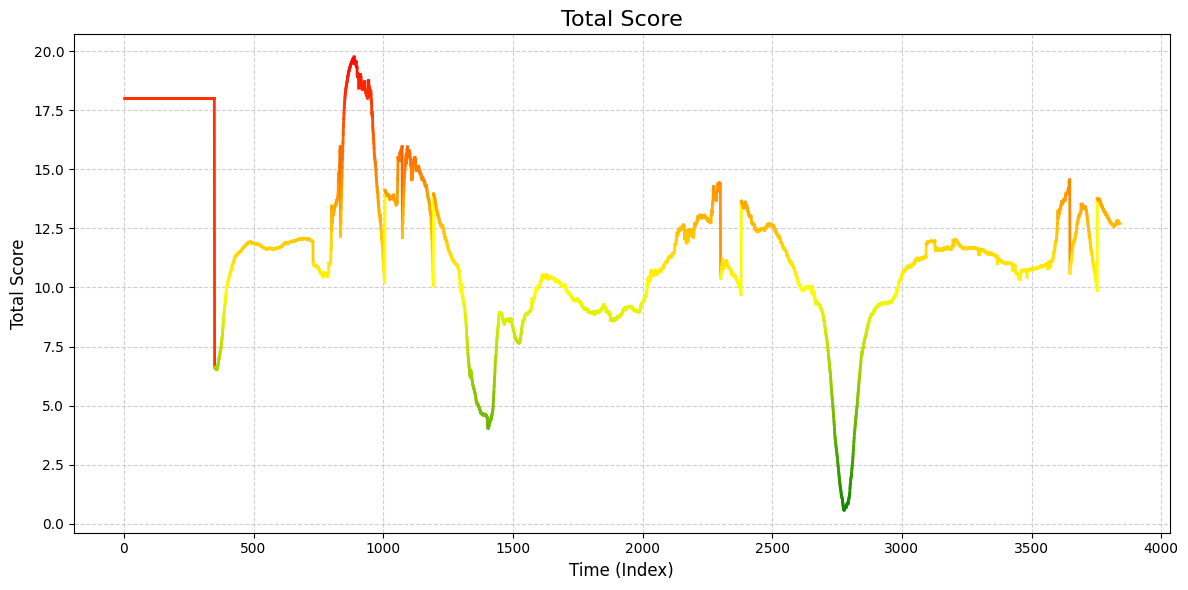

Document with plot saved as: XRP Analysis - 29-07-2025.docx


In [16]:
# Assuming df contains 'Total_Score' column and 'date' column (or just the index should be sorted)

# Sort the DataFrame by the index to ensure chronological order (if 'date' column is available, use it)
df = df.sort_index()  # Ensure data is sorted by the index (which might represent time in this case)

# Create a custom colormap: Green (0) -> Yellow (mid) -> Red (20)
cmap = LinearSegmentedColormap.from_list('score_colormap', ['green', 'yellow', 'red'], N=256)

# Normalize the Total_Score values between 0 and 20
norm = plt.Normalize(vmin=0, vmax=20)

# Create a color array based on the Total_Score values
colors = [cmap(norm(score)) for score in df['Total_Score']]

# Generate the plot
plt.figure(figsize=(12, 6))

# Plot the line with color gradient for each segment
for i in range(len(df) - 1):
    plt.plot([i, i + 1], [df['Total_Score'].iloc[i], df['Total_Score'].iloc[i + 1]], 
             color=colors[i], lw=2)

# Add title and labels
plt.title('Total Score', fontsize=16)
plt.xlabel('Time (Index)', fontsize=12)
plt.ylabel('Total Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to avoid clipping
plt.tight_layout()

# Save the plot as an image
plot_filename = 'total_score_plot.png'
plt.savefig(plot_filename)  # Save the plot as an image

# Show the plot
plt.show()

# Add plot to the document
image_paragraph = doc.add_paragraph()
image_paragraph.add_run().add_picture(plot_filename, width=Inches(7))
image_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER  # Center the image

# Save the document
doc.save(doc_filename)

# Confirm the document was saved
print(f"Document with plot saved as: {doc_filename}")

# Convert DocX do PDF

# Export to excel (database)

In [17]:
df.to_excel('XRP_EUR_data.xlsx') 